In [1]:
import sys

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import logging

import common
import util
importlib.reload(common)
importlib.reload(util)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df, load_df
from common import save_session, load_session

from util import show_importances
from util import split_X_y_all, split_X_y, split_data
from util import empty_features, column_feature, str_contains

from pbar import Pbar

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converters e.g. for datetime in plots
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Vytvorenie materialized views kvoli obmedzeniu datovej mnoziny

In [3]:
REFRESH_MVIEWS = False

In [4]:
mviews_queries = [
    # iba clanky z monitorov v kategoriach 'english' a 'medical' + publikovane po 'zaciatok-monitoringu'
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles CASCADE;
    CREATE MATERIALIZED VIEW new_articles AS (
    SELECT *
    FROM article
    WHERE monitor_id in (1, 4, 5, 7, 8, 9, 10)
      AND published_at >= '2019-10-21 00:00:00.000000');
    ''',
    
    # maximalne id pozorovania pre danu kombinaciu (url, datum)
    '''
    DROP MATERIALIZED VIEW IF EXISTS article_fb_engagement_per_day CASCADE;
    CREATE MATERIALIZED VIEW article_fb_engagement_per_day AS (
    SELECT max(id) last_id_on_day, related_object_url as url, extracted_at::date as sync_on_day
    FROM feedback_facebook
    GROUP BY url, sync_on_day);
    ''',
    
    # fb popularita + url + rozdiel medzi datumom publikovania a datumom ziskania dat z FB
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles_fb_engagement CASCADE;
    CREATE MATERIALIZED VIEW new_articles_fb_engagement AS (
    SELECT fb.id,
           fb.related_object_url                     as url,
           fb.reaction_count,
           fb.comment_count,
           fb.share_count,
           fb.comment_plugin_count,
           afepd.sync_on_day,
           na.published_at,
           afepd.sync_on_day - na.published_at::date as days_after_publication
    FROM article_fb_engagement_per_day afepd
             JOIN feedback_facebook fb ON fb.id = afepd.last_id_on_day
             JOIN new_articles na ON na.url = afepd.url);
    '''
]

if REFRESH_MVIEWS:
    with engine.connect() as connection:
        for q in mviews_queries:
            connection.execute(q)

In [5]:
main_view = '''
CREATE OR REPLACE VIEW main_articles_view AS
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       raw_body,
       a.published_at,
       extracted_at,
       category,
       other_info,
       coalesce(imgc.cnt, 0)            as image_count,
       coalesce(vidc.cnt, 0)            as video_count,
       aut.name                         as author_name,
       s.id                             as source_id,
       s.name                           as source_name,
       s.url                            as source_url,
       stype                            as source_type,
       is_reliable::integer             as source_is_reliable,
       av.veracity                      as av_veracity,
       coalesce(claims_false, 0)        as av_claims_false,
       coalesce(claims_mostly_false, 0) as av_claims_mostly_false,
       coalesce(claims_mixture, 0)      as av_claims_mixture,
       coalesce(claims_mostly_true, 0)  as av_claims_mostly_true,
       coalesce(claims_true, 0)         as av_claims_true,
       coalesce(av.claims_unknown, 0)   as av_claims_unknown
FROM new_articles a
         JOIN source s on a.source_id = s.id
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'image'
                    GROUP BY article_id) imgc ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'video'
                    GROUP BY article_id) vidc ON a.id = vidc.article_id
         LEFT JOIN article_veracity av on a.id = av.article_id
WHERE s.is_reliable IS NOT NULL;
'''
with engine.connect() as connection:
     connection.execute(main_view)

In [6]:
# - obsah clanku (+meta)
# - meno autora
# - pocet obrazkov / videii
# - pocet claimov
# - veracity (podla claimov)
# - zdroj (nazov, url)
# - anotacia doveryhodnosti zdroja

df = pd.sql('SELECT * FROM main_articles_view;')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24200 entries, 0 to 24199
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      24200 non-null  int64         
 1   url                     24200 non-null  object        
 2   title                   24200 non-null  object        
 3   perex                   18922 non-null  object        
 4   body                    24166 non-null  object        
 5   raw_body                24198 non-null  object        
 6   published_at            24200 non-null  datetime64[ns]
 7   extracted_at            24200 non-null  datetime64[ns]
 8   category                16624 non-null  object        
 9   other_info              24195 non-null  object        
 10  image_count             24200 non-null  int64         
 11  video_count             24200 non-null  int64         
 12  author_name             24200 non-null  object

In [8]:
# url, popularita na fb, rozdiel sync - publikovanie (max 30 dni)

DAYS_AFTER_POP_CUTOUT = 10

fb = pd.sql(f'''

SELECT url,
       reaction_count,
       share_count,
       comment_count,
       comment_plugin_count,
       sync_on_day,
       days_after_publication
FROM new_articles_fb_engagement
WHERE days_after_publication BETWEEN 0 AND {DAYS_AFTER_POP_CUTOUT}
AND url in (SELECT url FROM main_articles_view);
''')

In [9]:
assert fb.days_after_publication.max() <= DAYS_AFTER_POP_CUTOUT

In [10]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169027 entries, 0 to 169026
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   url                     169027 non-null  object
 1   reaction_count          169027 non-null  int64 
 2   share_count             169027 non-null  int64 
 3   comment_count           169027 non-null  int64 
 4   comment_plugin_count    169027 non-null  int64 
 5   sync_on_day             169027 non-null  object
 6   days_after_publication  169027 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 9.0+ MB


In [11]:
def append_popularity_columns(df, fb):
    df = df.copy()
    fb = fb.copy()
    
    cols = [
        'url',
        'days_after_publication',
        'reaction_count',
        'share_count',
        'comment_count'
    ] 
    
    fb = fb[cols].pivot_table(index='url',
                         columns='days_after_publication')
    fb.columns = [f'fb_ad_{j}_{i}' for i,j in fb.columns.values]
    
    df = df.query("url in @fb.index")
    df = pd.concat((df.set_index('url'), fb), axis=1, join='inner')
    return df.set_index('id')

In [12]:
def append_fb_pop_sum(df):
    df = df.copy()
    for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
        cols = [
            f'fb_ad_{i}_comment_count',
            f'fb_ad_{i}_share_count',
            f'fb_ad_{i}_reaction_count'
        ]
        df[f'fb_popularity_ad_{i}'] = df[cols].apply(np.sum, axis=1)
    return df

In [13]:
xdf = append_popularity_columns(df, fb)
xdf = append_fb_pop_sum(xdf)

df = xdf

2020-05-06 17:38:54,619 : INFO : Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-05-06 17:38:54,620 : INFO : NumExpr defaulting to 8 threads.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18635 entries, 431065 to 812426
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    18635 non-null  object        
 1   perex                    15047 non-null  object        
 2   body                     18605 non-null  object        
 3   raw_body                 18634 non-null  object        
 4   published_at             18635 non-null  datetime64[ns]
 5   extracted_at             18635 non-null  datetime64[ns]
 6   category                 13051 non-null  object        
 7   other_info               18631 non-null  object        
 8   image_count              18635 non-null  int64         
 9   video_count              18635 non-null  int64         
 10  author_name              18635 non-null  object        
 11  source_id                18635 non-null  int64         
 12  source_name              1

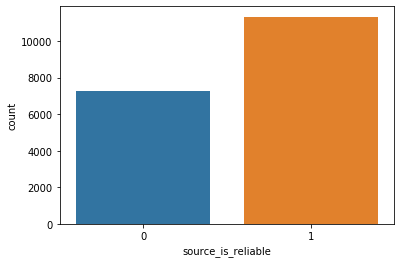

In [15]:
sns.countplot(x='source_is_reliable', data=df)

In [37]:
df.source_is_reliable.value_counts()

1    9068
0    6390
Name: source_is_reliable, dtype: int64

In [38]:
print(9068 / (9068 + 6390))

0.5866218139474706


In [39]:
print(6390 / (9068 + 6390))

0.41337818605252946


In [16]:
for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
    col = f'fb_ad_{i}_reaction_count'
    
    nan_cnt = df[col].isna().sum()
    not_nan_cnt = df[col].notna().sum()
    
    print(f'd={i}\ttotal={df[col].size}\tNaN_count = {nan_cnt}\tNotNaN_count = {not_nan_cnt}')

d=0	total=18635	NaN_count = 9283	NotNaN_count = 9352
d=1	total=18635	NaN_count = 4344	NotNaN_count = 14291
d=2	total=18635	NaN_count = 3381	NotNaN_count = 15254
d=3	total=18635	NaN_count = 2759	NotNaN_count = 15876
d=4	total=18635	NaN_count = 2344	NotNaN_count = 16291
d=5	total=18635	NaN_count = 2172	NotNaN_count = 16463
d=6	total=18635	NaN_count = 2144	NotNaN_count = 16491
d=7	total=18635	NaN_count = 2224	NotNaN_count = 16411
d=8	total=18635	NaN_count = 2546	NotNaN_count = 16089
d=9	total=18635	NaN_count = 2494	NotNaN_count = 16141
d=10	total=18635	NaN_count = 2267	NotNaN_count = 16368


In [17]:
from sklearn.impute import KNNImputer

In [18]:
reactions = [f'fb_ad_{i}_reaction_count' for i in range(0, DAYS_AFTER_POP_CUTOUT + 1)]
comments = [f'fb_ad_{i}_comment_count' for i in range(0, DAYS_AFTER_POP_CUTOUT + 1)]
shares = [f'fb_ad_{i}_share_count' for i in range(0, DAYS_AFTER_POP_CUTOUT + 1)]
popularity = [f'fb_popularity_ad_{i}' for i in range(0, DAYS_AFTER_POP_CUTOUT + 1)]

def knn_input(df, cols):
    imputer = KNNImputer()
    return imputer.fit_transform(df[cols])  

df[reactions] = knn_input(df, reactions)
df[comments] = knn_input(df, comments)
df[shares] = knn_input(df, shares)

In [19]:
for r,c,s,p in zip(reactions, comments, shares, popularity):
    df[p] = df[r] + df[c] + df[s]

In [20]:
df[popularity] = df[popularity].round()

In [21]:
for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
    col = f'fb_ad_{i}_reaction_count'
    
    nan_cnt = df[col].isna().sum()
    not_nan_cnt = df[col].notna().sum()
    
    print(f'd={i}\ttotal={df[col].size}\tNaN_count = {nan_cnt}\tNotNaN_count = {not_nan_cnt}')

d=0	total=18635	NaN_count = 0	NotNaN_count = 18635
d=1	total=18635	NaN_count = 0	NotNaN_count = 18635
d=2	total=18635	NaN_count = 0	NotNaN_count = 18635
d=3	total=18635	NaN_count = 0	NotNaN_count = 18635
d=4	total=18635	NaN_count = 0	NotNaN_count = 18635
d=5	total=18635	NaN_count = 0	NotNaN_count = 18635
d=6	total=18635	NaN_count = 0	NotNaN_count = 18635
d=7	total=18635	NaN_count = 0	NotNaN_count = 18635
d=8	total=18635	NaN_count = 0	NotNaN_count = 18635
d=9	total=18635	NaN_count = 0	NotNaN_count = 18635
d=10	total=18635	NaN_count = 0	NotNaN_count = 18635


In [22]:
df.source_name.value_counts()

naturalnews.com                  2307
medicinenet.com                  1860
statnews.com                     1285
medicaldaily.com                 1275
latimes.com                      1259
nytimes.com                      1219
foxnews.com                      1091
neurosciencenews.com              979
themindunleashed.com              963
webmd.com                         801
thenewsdoctors.com                655
healthy-holistic-living.com       481
healthnutnews.com                 441
healthcentral.com                 438
emedicinehealth.com               350
ageofautism.com                   241
medicalnewstoday.com              237
realfarmacy.com                   221
healthimpactnews.com              211
who.int                           201
organicfacts.net                  192
hsionline.com                     191
consciouslifenews.com             186
infowars.com                      179
naturalhealth365.com              176
collective-evolution.com          133
alliancefora

In [23]:
df.source_is_reliable.value_counts()

1    11336
0     7299
Name: source_is_reliable, dtype: int64

In [24]:
from bs4 import BeautifulSoup
import re
import unicodedata

def clear_text(text):
    if text is None:
        return ''

    text = BeautifulSoup(text, features='html.parser').text
    text = text.lower()
    text = text.replace('\r', '')
    text = text.replace('\n', ' ')
    text = unicodedata.normalize('NFKD', text)

    return text

def clear_column(df, column):
    df[column] = df[column].apply(clear_text)

def clear_columns(df, columns):
    pbar_conf = {
        'refresh_rate': 1,
        'action_names': columns
    }
        
    for c in Pbar(columns, **pbar_conf):
        clear_column(df, c)

In [25]:
clear_columns(df, ['title', 'perex', 'body'])

[==================================================] -- 3 / 3 -- (finished)2 / 33


In [26]:
# drop rows without body
df = df[~df.body.isnull()]
df = df[~df.raw_body.isnull()]
df = df[~df.title.isnull()]
df = df[df.body.str.len() > 0]

In [27]:
# remove short articles (e.g. ending at paywall)
df = df[df.body.str.len() > 6 * 250]

In [28]:
df['body'] = df.perex + df.body

In [29]:
def extract_urls(text):
    soup = BeautifulSoup(text, features='html.parser')
    
    tags = soup.find_all('a')
    
    return list(set([tag for tag in map(lambda x: x.get('href'), tags) if tag is not None]))

def remove_urls(text, urls):
    for u in urls:
        text = re.sub(re.escape(u), '', text, flags=re.IGNORECASE)
    
    return text

In [30]:
df['body_urls'] = df.raw_body.apply(extract_urls)
df['body'] = df.apply(lambda r: remove_urls(r.body, r.body_urls), axis=1)

In [31]:
df.source_name.value_counts()

naturalnews.com                  2301
medicinenet.com                  1607
medicaldaily.com                 1273
latimes.com                      1141
foxnews.com                       962
neurosciencenews.com              957
themindunleashed.com              956
statnews.com                      753
webmd.com                         642
nytimes.com                       589
healthy-holistic-living.com       481
healthnutnews.com                 392
medicalnewstoday.com              235
healthcentral.com                 231
emedicinehealth.com               230
healthimpactnews.com              206
organicfacts.net                  192
realfarmacy.com                   182
naturalhealth365.com              176
who.int                           172
ageofautism.com                   171
hsionline.com                     171
consciouslifenews.com             170
infowars.com                      157
collective-evolution.com          133
allianceforadvancedhealth.com     107
vaccineimpac

### Save final data

In [32]:
save_df(df, 'final_data.pickle')